Date: 3/2/2023 <br>
Author: Amparo Godoy Pastore

# Introduction

This project aims to simulate and visualize orbital maneuvers using numerical integration of equations of motion. Specifically, it focuses on simulating a Hohmann transfer orbit, which is used to transfer a spacecraft from one circular orbit to another by way of an elliptical orbit. The project also involves using a Hohmann transfer orbit to bring a satellite from a low Earth orbit to an orbit around the Moon. <br> 

As we have seen in the last couple of weeks, computational methods of analyzing data to make accurate predictions are relevant in a variety of areas, and orbital mechanics is no exception. The significance of this project, therefore, lies in understanding the role that computational science plays in orbital mechanics and basic simulation techniques used in space mission planning.

# 1. Preliminaries


<div class="alert alert-block alert-danger">
<b>Task 0:</b>  


First, we import the necessary libraries.

In [1]:
import numpy as np
from numpy.linalg import norm
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import vpython as vp
import itertools as itt

<IPython.core.display.Javascript object>

Here, we define two functions: `compute_orbits` and `animate`. The former computes the trajectories of a list of N objects in gravitational interaction, while the latter animates 3D trajectories. 

In [2]:
def compute_orbits(R0, V0, M, tmax=10, dt=1e-2, center_of_mass_frame=True, rtol=1e-6, atol=1e-6):
    '''
    Compute the trajectories of a list of N objects in gravitational interaction.
    
    Arguments:
      R0:   Initial position of each object (Nx3 array).
      V0:   Initial velocity of each object (Nx3 array).
      M:    Mass of each object (N array).
      tmax: Duration of the integration.
      dt:   Time step of the integration.
    Output:
      T: Array of times (1D array of size M where M is the 
         number of time steps).
      R: Array of positions (Nx3xM array).
         R[i,j,k] is the j-th position coordinate (0=x, 1=y, 2=z) 
         of object i at time step k.
      V: Array of velocities (Nx3xM array).
         V[i,j,k] is the j-th velocity coordinate (0=x, 1=y, 2=z) 
         of object i at time step k.
    '''
    
    # Make sure the initial conditions are numpy arrays.
    r0 = np.array(R0)
    v0 = np.array(V0)
    m  = np.array(M)
    n  = len(m) # r0, v0, and m should all have the same length
    assert(r0.shape[0]==v0.shape[0]==len(m))
    
    # Switch to the frame of the center of mass.
    if center_of_mass_frame:
        r_  = np.sum(m[:,None]*r0,axis=0)/np.sum(m) # Position of the center of mass.
        v_  = np.sum(m[:,None]*v0,axis=0)/np.sum(m) # Velocity of the center of mass.
        r0 -= r_[None,:]
        v0 -= v_[None,:]

    # Create initial state variable.
    x0 = np.array([r0, v0]).flatten()

    # Specify the differential equation.
    def dxdt(t, x, n=n):
        r,v  = x.reshape((2,n,3))
        drdt = v
        dvdt = np.zeros((n,3))
        for i in range(n):
            for j in range(i):
                rij = r[j]-r[i]
                fij = rij/norm(rij)**3
                dvdt[i] += m[j]*fij
                dvdt[j] -= m[i]*fij
        return np.array([drdt,dvdt]).flatten()
        
    sol = solve_ivp(dxdt, [0,tmax], x0, t_eval=np.arange(0,tmax,dt), atol=atol, rtol=rtol)
    R,V = sol.y.reshape((2,n,3,-1))
    return sol.t, R, V

# Function to animate 3D trajectories.
def animate(pos, sizes=None, rate=30):
    '''
    Animate the trajectories of a group of objects in 3D.
    
    Arguments:
      pos:   Position of the objects as a function of time. Nx3xM array where 
             N=number of objects, 3=number of spatial dimensions, and M=number of time steps.
      sizes: Masses of the objects. Used to control object sizes in the animation.
             Default: every object has the same size.
      rate:  Frame rate.
             Default: 30 frames/second.
    '''
    pos = np.atleast_3d(pos)
    pos = np.rollaxis(pos, 2, 0)
    # If user doesn't provide object sizes, draw radius=0.1.
    if sizes==None:
        sizes = [0.1]*pos.shape[1]
    # If user provides object sizes, rescale them logarithmically 
    # to get radii between 0.02 and 0.1  
    else:
        r1,r2 = 0.03,0.06 # range of sphere radii
        sizes = np.log(sizes)
        s1,s2 = sizes.min(),sizes.max()
        sizes = r1 + (r2-r1)*(sizes-s1)/(s2-s1)
    # Set up the scene.
    vp.scene.delete()
    vp.scene = vp.canvas()
    # Draw cartesian basis.
    for i,color in zip(range(3),[vp.color.red,vp.color.green,vp.color.blue]):
        axis = 0.2*vp.vec(*np.roll([1,0,0],i))
        vp.arrow(pos=vp.vec(0,0,0), axis=axis, color=color)
    # Draw the objects.
    opt     = dict(make_trail=True, interval=1, trail_radius=0.005)
    spheres = []
    colors  = itt.cycle([vp.color.white, vp.color.red, vp.color.green, vp.color.blue])
    colors  = [next(colors) for i in range(pos.shape[1])]
    for j in range(pos.shape[1]):
        spheres.append(vp.sphere(pos=vp.vec(*pos[0,j]), color=colors[j], radius=sizes[j], **opt))
    for i in range(pos.shape[0]):
        for j in range(pos.shape[1]):
            spheres[j].pos = vp.vec(*pos[i,j])
        vp.rate(rate)

# 2. Hohmann transfer orbit

In this section, we will use the `compute_orbits` function to calculate the trajectories of two objects during a Hohmann transfer orbit -a common and efficient way of transfering a spacecraft between two orbits of different radii. During the transfer, the spacecraft follows an elliptical trajectory that intersects both circular orbits.

Once the trajectories have been calculated, the `animate` function will be used to visualize the orbits in 3D space.

<div class="alert alert-block alert-danger">
<b>Task 1:</b>  
</div>

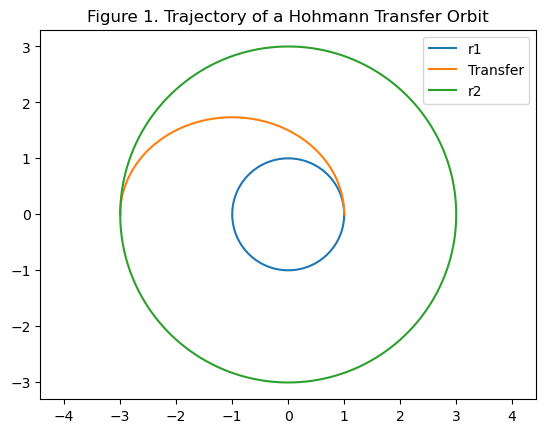

In [3]:
# Define initial state.
m  = [1,1e-4]         # Masses.
d1 = 1                # Radius
d2 = 3 
v1 = np.sqrt(m[0]/d1) # Velocity needed for circular orbit.
t1 = 2*np.pi*d1/v1    # Period of the circular orbit.

# PHASE 1
R1i = np.array([[0.,0,0],[d1,0,0]])
V1i = np.array([[0.,0,0],[0,v1,0]])
T1,R1,V1 = compute_orbits(R1i, V1i, m, t1) # Simulate.

# PHASE 2
v2 = np.sqrt(m[0]*(2/d1 - 2/(d1+d2))) # Update velocity
t2 = np.pi*np.sqrt((d1+d2)**3 / 8*m[0]) # Update period
R2i = R1[:, :, -1] # Retrieve last position and velocity of the satellite
V2i = V1[:, :, -1]
V2i[1] = (V2i[1] / norm(V2i[1])) * v2
T2,R2,V2 = compute_orbits(R2i, V2i, m, tmax = t2)

# #PHASE 3
v3 = np.sqrt(m[0]/d2) # Update velocity and period 
t3 = 2*np.pi*d2/v3 
R3i = R2[:, :, -1]
V3i = V2[:, :, -1]
V3i[1] = (V3i[1] / norm(V3i[1])) * v3
T3,R3,V3 = compute_orbits(R3i, V3i, m, t3)

# Plot trajectories.
plt.plot(R1[1,0],R1[1,1], label = 'r1')
plt.plot(R2[1,0],R2[1,1], label = 'Transfer')
plt.plot(R3[1,0],R3[1,1], label = 'r2')
plt.axis('equal')
plt.title('Figure 1. Trajectory of a Hohmann Transfer Orbit')
plt.legend()
plt.show()

_Figure 1_ exemplifies a Hohmann transfer orbit from radius $r_1=1$ to $r_2=3$ for an object of mass $m=10^{-4}$ orbiting an object of mass $M=1$

In [4]:
# ANIMATE
R = np.concatenate([R1,R2,R3], axis = 2) 
# animate(R[:,:,::5], sizes=m)

Shown above is the 3D animation of the Hohmann transfer orbit.

# 3. Translunar injection orbit

In this section we will be sending a satellite from a low orbit around the Earth into an orbit around the Moon, this is a translunar injection orbit or TLI orbit. The numerical values are inaccurate, but the basic principles stand.

The planet is represented by object 0 with mass $m_0=1$, the moon by object 1 with mass $m_1=10^{-2}$, and the satellite by object 2 with mass $m_2=10^{-4}$. Object 1 is in a circular orbit around object 0 with radius $r_1=1$. Object 2 is initially in a circular orbit around object 0 with radius $r_2=0.1$. 

We use a Hohmann transfer orbit to bring the satellite near the moon, then perform the appropriate velocity change to put it into a circular orbit of radius $r_3=0.05$ around the moon.

<div class="alert alert-block alert-danger">
<b>Task 2:</b>  
Follow the steps above. Visualize the result in matplotlib, then in matplotlib in the frame of reference of the moon (same axes, moon at the origin), then with the `animate` function.
</div>

First, we set up the intial state and compute the orbits for $t_1 = 0.15$. We then use the same approach as in section 2, the Hohmann transfer orbit, to bring the satellite to the orbit of the moon. _Figure 2_ and _4_ illsutrate the steps taken to obtain the final TLI orbit shown in _Figure 5_

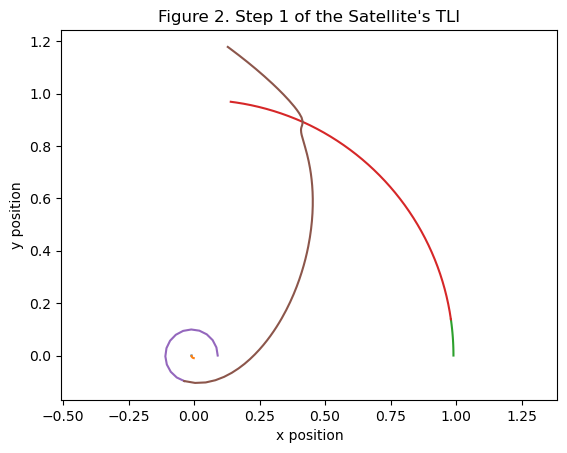

In [5]:
# Initial conditions
m = [1, 1e-2, 1e-4]
r1, r2, r3 = 1, 0.1, 0.05
t1 = 0.15
v1 = np.sqrt(m[0]/r1)
v2 = np.sqrt(m[0]/r2)
V0 = [[0., 0, 0], [0, v1, 0], [0, v2, 0]]
R0 = [[0., 0., 0.], [r1, 0, 0], [r2, 0, 0]]

# PHASE 1
T1,R1,V1 = compute_orbits(R0, V0, m, t1) # Simulate orbits.

# PHASE 2
v2 = np.sqrt(m[0]*(2/r2 - 2/(r2+r1)))
t2 = np.pi*np.sqrt((r1+r2)**3 / 8*m[0])
R2i = R1[:, :, -1]
V2i = V1[:, :, -1]
V2i[2] = (V2i[2] / norm(V2i[2])) * v2 # Changing the velocity of the rocket
T2,R2,V2 = compute_orbits(R2i, V2i, m, tmax = t2) 

for i in range(3):
    plt.plot(R1[i,0],R1[i,1])
    plt.plot(R2[i,0],R2[i,1])

plt.axis('equal')
plt.title('Figure 2. Step 1 of the Satellite\'s TLI')
plt.xlabel('x position')
plt.ylabel('y position')
plt.show()

_Figure 2_ shows the satellite reaching the orbit of the moon right as the moon passes by and receiving a gravity assist, meaning the satellite gains speed from its interaction with the moon and escapes the earth-moon system altogether.

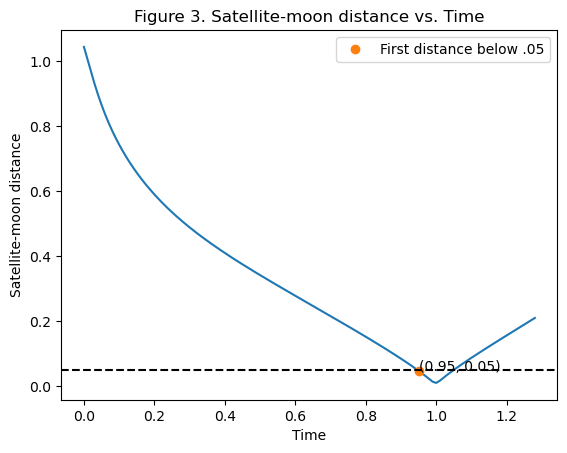

In [6]:
# Compute satellite-moon distances
distances = norm(R2[2] - R2[1], axis=0)

for i, distance in enumerate(distances):
    if distance < 0.05:
        point = (T2[i], distance)
        break
        
# Plot against time
plt.plot(T2, distances)
plt.plot(point[0], point[1], 'o', label = 'First distance below .05')
plt.title('Figure 3. Satellite-moon distance vs. Time')
plt.xlabel('Time')
plt.ylabel('Satellite-moon distance')
plt.axhline(0.05, color='k', ls='--')
plt.annotate('(%.2f, %.2f)' % point, xy=point)
plt.legend()

As _Figure 3_ illustrates, the satellite-moon distance first drops below $r_3=0.05$ at $t = 0.95$. Having identified this, we can now modify the transfer orbit simulation so that it stops at the appropriate time.

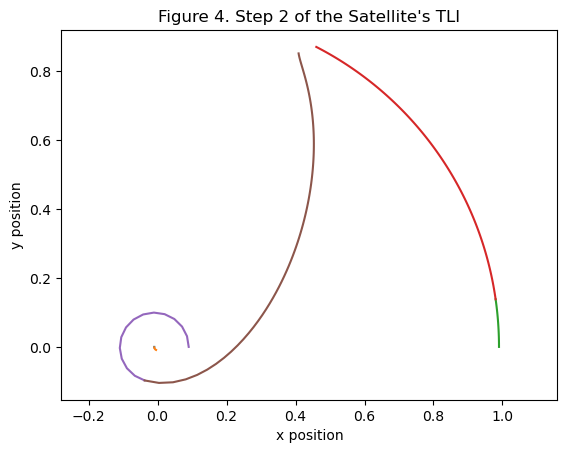

In [7]:
# Modify the transfer orbit simulation so it stops at the time you found in the previous step.
T2,R2,V2 = compute_orbits(R2i, V2i, m, tmax = point[0]) 

for i in range(3):
    plt.plot(R1[i,0],R1[i,1])
    plt.plot(R2[i,0],R2[i,1])

plt.axis('equal')
plt.title('Figure 4. Step 2 of the Satellite\'s TLI')
plt.xlabel('x position')
plt.ylabel('y position')
plt.show()

In _Figure 4_ the transfer orbit stops at $t = 0.95$. Now, we'll change the satellite's velocity to put it in a circular orbit around the moon.

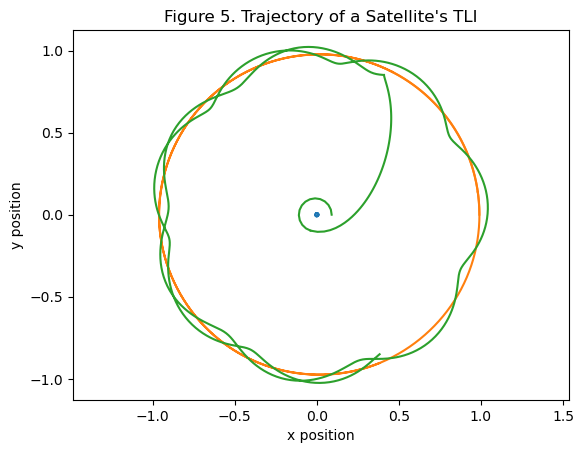

In [14]:
# Initial conditions after phase 2
R3i = R2[:, :, -1]
V3i = V2[:, :, -1]

# Compute the position of the satellite relative to the moon
distance_sm = norm(R2[1][:,-1] - R2[2][:,-1], axis=0) # Distance between satellite and moon
v_new = np.sqrt(m[1]/distance_sm) # New velocity of the satellite relative to the moon
radial = (R2[1][:,-1] - R2[2][:,-1])/distance_sm # Radial unit vector
# Perpendicular vector to radial unit vector
perp = radial
perp[0], perp[1] = radial[1], -radial[0]
perp = perp * v_new

v_new2 = perp + V2[1,:,-1] # New velocity of the satellite relative to the origin
V3i[2] = v_new2 # Updating velocity of the satellite in the list

# Phase 3. Simulating orbits
T3,R3,V3 = compute_orbits(R3i, V3i, m) 

# Plot
colors = ['C0', 'C1', 'C2']
for i in range(3):
    plt.plot(R1[i,0], R1[i,1], color=colors[i])
    plt.plot(R2[i,0], R2[i,1], color=colors[i])
    plt.plot(R3[i,0], R3[i,1], color=colors[i])

plt.axis('equal')
plt.title('Figure 5. Trajectory of a Satellite\'s TLI')
plt.xlabel('x position')
plt.ylabel('y position')
plt.show()

The trajectory of the satellite's translunar injection can be visualized in the xy-plane by _Figure 5_, shown above, and in 3D by the animation below.

In [9]:
# ANIMATE
R = np.concatenate([R1,R2,R3], axis=2) 
# animate(R[:,:,::5], sizes=m)

Lastly, we'll change the frame of reference to that of the moon.

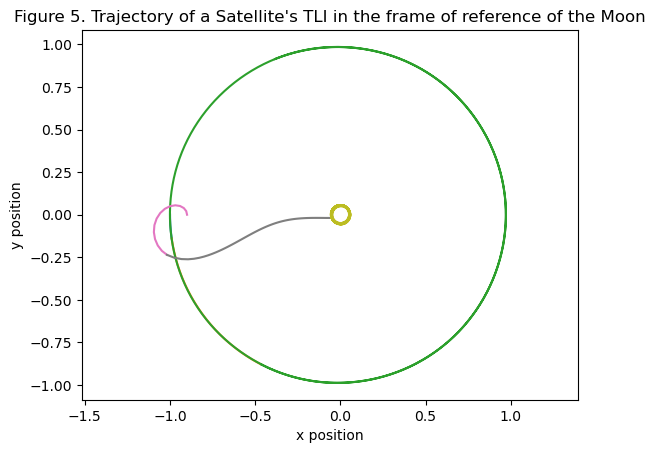

In [13]:
# Compute the position and velocity of the Moon relative to the Earth in the original frame of reference
R1_moon = R1[2][:, -1]
R2_moon = R2[2][:, -1] 
R3_moon = R3[2][:, -1]

# Plot
for i in range(3):   
    plt.plot(R1[i,0] - R1[1,0], R1[i,1] - R1[1,1])
    plt.plot(R2[i,0] - R2[1, 0], R2[i,1] - R2[1,1])
    plt.plot(R3[i,0] - R3[1, 0], R3[i,1] - R3[1, 1])

plt.axis('equal')
plt.title('Figure 5. Trajectory of a Satellite\'s TLI in the frame of reference of the Moon')
plt.xlabel('x position')
plt.ylabel('y position')
plt.show()

<div class="alert alert-block alert-warning" style="background-color:#f0ddcc; color:#663300">
<b>Extra Task 1:</b>  
Identify viable transfer windows, i.e., times at which starting the Hohmann transfer will bring the rocket within 0.05 distance units of the moon.

To do that, first write a function that takes the duration of phase 1 (time spent in the original orbit before starting the Hohmann transfer; in task 2 it was 0.15) as input, simulates three quarters of the transfer orbit (1.5 times the Δt from task 2), and returns how close the rocket came to the moon (compute the rocket-moon distance throughout the transfer orbit, then output its minimum). Then, plot this distance of closest approach as a function of the duration of phase 1. Put a 0.05 horizontal dashed line on the same plot. Places where the distance-of-closest-approach curve is below the 0.05 line are viable times to start the transfer orbits.
</div>

# Conclusion

To conclude, in this project we successfully modeled two important orbital maneuvers - the Hohmann transfer and the translunar injection. We  were able to calculate the necessary parameters and visualize the resulting orbits.

The Hohmann transfer proved to be an efficient method of transferring a spacecraft between two circular orbits of different radii. Further, our simulation of a translunar injection orbit provided a visualization of the spacecraft's trajectory as it escaped Earth's gravity and began its journey to the orbit of the moon.

Overall, we have demonstrated one of the many applications of RK numerical integration: simulation and visualization of orbital transfers and translunar injections. The ability to accurately simulate and predict orbital motion is crucial in space exploration, however, the computational methods and techniques that we have used in this project are valuable tools that can be applied to solving a variety of problems in different disciplines. 